# Dot products and norms
> For each embedding, what are their distributions?

In [1]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

In [2]:
import numpy as np
import pandas as pd
import geoopt
import torch
from tqdm.notebook import tqdm


DEVICE = "cuda"
MAN = geoopt.PoincareBall().to(DEVICE)

for name in mlrepo.varm_keys():
    print(name)
    embeddings = mlrepo.varm[name]
    if name.startswith("H"):
        embeddings = torch.tensor(embeddings).to(DEVICE)
        log_embeddings = MAN.logmap0(embeddings)
        norms = MAN.dist0(embeddings).cpu().numpy()
        cf = MAN.lambda_x(torch.zeros(embeddings.shape[1]))
        dps = (cf * log_embeddings @ log_embeddings.T).cpu().numpy()
    elif name == "dnabert-s":
        embeddings = torch.tensor(embeddings).to(DEVICE)
        norms = torch.linalg.norm(embeddings, dim=1).cpu().numpy()
        # dps = (embeddings @ embeddings.T).cpu().numpy()
        dps = []
        for row in tqdm(embeddings):
            dp_row = (row @ embeddings.T).cpu().numpy()
            dps.append(dp_row)
        dps = np.stack(dps)
    else:
        norms = np.linalg.norm(embeddings, axis=1)
        dps = embeddings @ embeddings.T

    assert norms.shape == (mlrepo.n_vars,)
    assert dps.shape == (mlrepo.n_vars, mlrepo.n_vars)

    # all_norms[name] = norms
    # all_dps[name] = dps[np.triu_indices_from(dps, k=1)] # Save memory

    np.save(f"../results/norms_dot_products/{name}_norms.npy", norms)
    np.save(f"../results/norms_dot_products/{name}_dps.npy", dps[np.triu_indices_from(dps, k=1)])

E128
E16
E2
E32
E4
E64
E8
H128
H16
H2
H32
H4
H64
H8
dnabert-s


  0%|          | 0/27105 [00:00<?, ?it/s]

In [17]:
# Load a lightweight version

all_norms = {}
all_dps = {}

for name in mlrepo.varm_keys():
    norms = np.load(f"../results/norms_dot_products/{name}_norms.npy")
    dps = np.load(f"../results/norms_dot_products/{name}_dps.npy")

    # Make DPs square - reverse np.triu
    n = int((1 + np.sqrt(1 + 8 * len(dps))) / 2)
    full_matrix = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    full_matrix[triu_indices] = dps
    full_matrix = full_matrix + full_matrix.T
    np.fill_diagonal(full_matrix, 0)

    # Save the full matrix
    np.save(f"../results/norms_dot_products/{name}_cossims.npy", full_matrix)

    all_norms[name] = norms[:100]
    all_dps[name] = full_matrix[:100, :100] / (norms[:100] * norms[:100].T)

In [18]:
# Save a little version again
import pickle

pickle.dump((all_norms, all_dps), open("../results/norms_dot_products/norms_dps.pkl", "wb"))

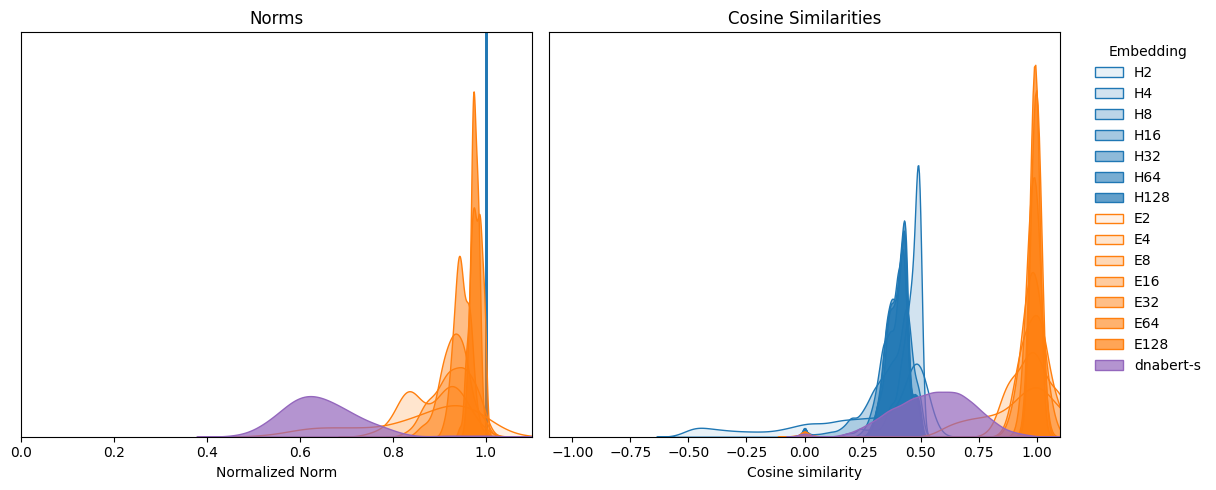

In [54]:
# Let's plot the norms
import matplotlib.pyplot as plt
import seaborn as sns

# Get more opaque with higher dimensions
opacities = {
    "H2": 0.1,
    "H4": 0.2,
    "H8": 0.3,
    "H16": 0.4,
    "H32": 0.5,
    "H64": 0.6,
    "H128": 0.7,
    "E2": 0.1,
    "E4": 0.2,
    "E8": 0.3,
    "E16": 0.4,
    "E32": 0.5,
    "E64": 0.6,
    "E128": 0.7,
    "dnabert-s": 0.7,
}

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for name in opacities.keys():
    if name == "dnabert-s":
        color = "C4"
    elif name.startswith("E"):
        color = "C1"
    else:
        color = "C0"
    all_norms_normalized = all_norms[name] / np.max(all_norms[name])
    sns.kdeplot(all_norms_normalized, fill=True, label=name, ax=axs[0], color=color, alpha=opacities[name])
    sns.kdeplot(all_dps[name].flatten(), fill=True, label=name, ax=axs[1], color=color, alpha=opacities[name])

axs[0].set_title(f"Norms")
axs[1].set_title(f"Cosine Similarities")
axs[0].set_ylim(0, 50)
axs[0].set_xlim(0, 1.1)
axs[1].set_ylim(0, 20)
axs[1].set_xlim(-1.1, 1.1)
for ax in axs:
    ax.set_ylabel(None)
    ax.set_yticks([])
axs[0].set_xlabel("Normalized Norm")
axs[1].set_xlabel("Cosine similarity")
axs[1].legend(loc="upper right", bbox_to_anchor=(1.3, 1), frameon=False, title="Embedding")
plt.tight_layout()

plt.savefig("../figures/norms_dot_products.pdf", dpi=300, bbox_inches="tight")